# Событийный анализ пользователей мобильного приложения

 ОПИСАНИЕ ПРОЕКТА


Стартап продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения.
Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?\
Далее исследуем результаты A/A/B-эксперимента замены шрифтов во всём приложении

ОПИСАНИЕ ДАННЫХ

EventName — название события;\
DeviceIDHash — уникальный идентификатор пользователя;\
EventTimestamp — время события;\
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

##  Откроем файл с данными и изучим общую информацию

In [349]:
#импортируем нужные библиотеки
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
import math as mth
import warnings
warnings.filterwarnings('ignore')
from plotly import graph_objects as go

In [350]:
#загрузим данные в переменную 'data'
try:
    data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

In [351]:
#общая информация
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [352]:
#выведем
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


##  Подготовим данные

Пропусков в данных нет. Столбец с данными о дате имеет тип int, менять  не будем, далее переименуем столбцы, добавим с датой с соответствующим типом, используя для преобразования данный столбец. Проверим данные на явные дубликаты

In [353]:
#присваиваем столбцам понятные названия
data.columns = ['event_name', 'user_id', 'event_time', 'group']

In [354]:
#проверим явные дубликаты
data.duplicated().sum()

413

In [355]:
#удалим дубликаты, кроме первого, сбросим индекс
data = data.drop_duplicates().reset_index(drop= True)

In [356]:
data.duplicated().sum()

0

In [357]:
# Проверим пользователей, которые могли участвовать в двух или нескольких группах одновременно
data.groupby('user_id').agg({'group':'nunique'}).query('group > 1').count()

group    0
dtype: int64

Дубликатов нет, поменяем типы данных времени

In [358]:
#переведем дату в нужный формат
data['event_time'] = pd.to_datetime(data['event_time'],unit='s')

### Добавим отдельный столбец дат

In [359]:
data['date'] = data['event_time'].astype('datetime64[D]')

In [360]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


Набор данных достаточен. Данные прошли предобработку и соответствуют необходимому уровню качества для дальнейшего интеллектуального анализа и проверке гипотез

## Изучим и проверим данные

In [361]:
#всего событий
data['user_id'].count()

243713

In [362]:
#уникальных пользователей
data['user_id'].nunique()

7551

In [363]:
#cколько всего событий в логе
data.groupby('event_name').agg({'user_id': 'count'}).sort_values(by='user_id', ascending=False)

,user_id
event_name,
MainScreenAppear,119101
OffersScreenAppear,46808
CartScreenAppear,42668
PaymentScreenSuccessful,34118
Tutorial,1018


In [364]:
# 119205    MainScreenAppear           главный экран
# 46825     OffersScreenAppear         каталог
# 42731     CartScreenAppear           корзина
# 34313     PaymentScreenSuccessful    успешная оплата
# 1052      Tutorial                   руководство       

Число событий в логах соответствуют продуктовой воронке, а вот руководство читают редко

In [365]:
#число уникальных пользователей в логах
data.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)

,user_id
event_name,
MainScreenAppear,7439
OffersScreenAppear,4613
CartScreenAppear,3749
PaymentScreenSuccessful,3547
Tutorial,847


In [366]:
#Сколько в среднем событий приходится на пользователя
(data['user_id'].count()/data['user_id'].nunique()).round(2)

32.28

In [367]:
data['user_id'].describe()

count    2.437130e+05
mean     4.627963e+18
std      2.642723e+18
min      6.888747e+15
25%      2.372212e+18
50%      4.623192e+18
75%      6.932517e+18
max      9.222603e+18
Name: user_id, dtype: float64

32 события в среднем на каждого пользователя 

In [368]:
#найдем минимальную дату событий
data['date'].min()

Timestamp('2019-07-25 00:00:00')

In [369]:
#найдем максимальную дату
data['date'].max()

Timestamp('2019-08-07 00:00:00')

Данные за временной период: 2019.7.25 - 2019.8.7

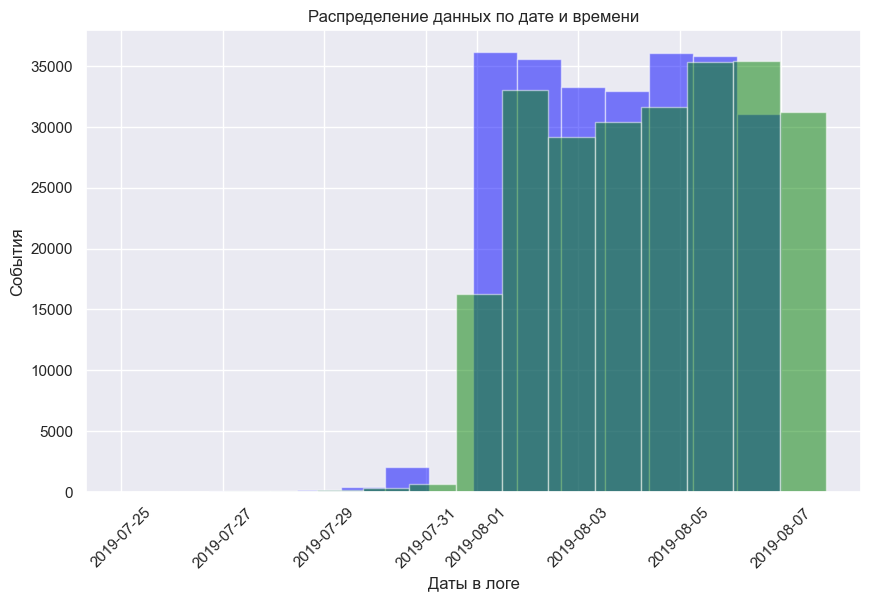

In [370]:
#Построим гистограмму по дате и времени
plt.figure(figsize=(10,6))
plt.xticks(rotation=45)
plt.title('Распределение данных по дате и времени')
plt.xlabel('Даты в логе')
plt.ylabel('События')
data['date'].hist(bins=15, alpha=0.5, color='blue')
data['event_time'].hist(bins=15, alpha=0.5, color='green');

На гистограмме видно, как мало данных до 2019.08.01, они попали в выборку случайно. Данные в полном объеме поступали после этой даты. Будем считать период для анализа с 2019.8.01 по 2019.8.07. 

In [371]:
#сделаем срез с 2019.08.01
df = data.query('event_time >= "2019-08-01"').reset_index()

In [372]:
#Посчитаем сколько событий мы потеряли после среза, в %
"{0:.2%}".format(1-(df.shape[0]/data.shape[0]))

'1.16%'

In [373]:
#проверим вторым способом
"{0:.2%}".format(1-len(df)/len(data))

'1.16%'

1.16% событий, это несущественная потеря

In [374]:
#Посчитаем сколько пользователей мы потеряли после среза, в %
"{0:.2%}".format(1-df['user_id'].nunique()/data['user_id'].nunique())

'0.23%'

Еще меньше потеряли пользователей  0.23%

In [375]:
#Проверим, что у нас есть пользователи из всех трёх экспериментальных групп
df.groupby('group').agg({'user_id': 'nunique'}).reset_index()


,group,user_id
0,246,2484
1,247,2513
2,248,2537


Пользователи присутствуют во всех группах

## Изучим воронку событий

In [376]:
#Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте
df['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [377]:
# 7419      MainScreenAppear           главный экран
# 4593      OffersScreenAppear         каталог
# 3734      CartScreenAppear           корзина
# 3539      PaymentScreenSuccessful    успешная оплата
# 840       Tutorial                   руководство       

События выстраиваются в последовательную цепочку: MainScreenAppear - OffersScreenAppear - CartScreenAppear - PaymentScreenSuccessful, кроме одного - Tutorial, на руководство  можно перейти сразу после загрузки приложения или в любой другой момент. Можно исключить это действие, оно исказит общую картину.  \
Нужно отметить, каждое последующее событие меньше предыдущего - форма воронки

In [378]:
#создадим воронку событий с помощью функции groupby
event_funnel = df.groupby('event_name')\
.agg({'user_id': 'nunique'})\
.sort_values(by='user_id', ascending=False)\
.reset_index()
event_funnel 

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [379]:
#Посчитаем, сколько пользователей совершали каждое из этих событий и добавим новый столбец
event_funnel['proportion'] = (event_funnel['user_id']/df['user_id'].nunique()*100).round(1)
event_funnel = event_funnel.rename(columns={'user_id': 'total'})
event_funnel   

,event_name,total,proportion
0,MainScreenAppear,7419,98.5
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,49.6
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.1


In [380]:
#Посчитаем долю пользователей, которые хоть раз совершали событие
"{0:.0%}".format(df.query('event_name >= "1"')['user_id'].nunique()/df['user_id'].nunique())

'100%'

Все пользователи совершили хоть одно событие

In [381]:
#исключим Tutorial
df = df.query('event_name != "Tutorial"')
event_funnel = event_funnel.query('event_name != "Tutorial"')

In [382]:
#посчитаем долю пользователей совершивших следующее событие и потерю на каждом шаге с помощью функции shift()
#она сдвинет индекс на следующее событие
event_funnel['conversion'] = np.round(event_funnel['total']/event_funnel['total'].shift()*100, 1)
event_funnel['deprivation'] = 100 - event_funnel['conversion'] 
event_funnel.fillna('-')

,event_name,total,proportion,conversion,deprivation
0,MainScreenAppear,7419,98.5,-,-
1,OffersScreenAppear,4593,61.0,61.9,38.1
2,CartScreenAppear,3734,49.6,81.3,18.7
3,PaymentScreenSuccessful,3539,47.0,94.8,5.2


Больше всего пользователей теряется на переходе с главного экрана в каталог. Посчитаем долю пользователей, доходящих от первого события до оплаты.

In [383]:
round(event_funnel['total'][3]*100 / event_funnel['total'][0],1)

47.7

47.7% пользователей доходят до оплаты

In [384]:
#построим диаграмму воронки доли пользователей совершивших следующее событие с помощью go.funnel библиотеки plotly
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Воронка событий',
    y = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessfu"],
    x = event_funnel['proportion'],
    textinfo = "value"))
fig.update_layout(title_text='Воронка событий')

fig.show()

61.9% пользователей переходят с главного экрана в каталог\
81.3% пользователей переходят с каталога в корзину\
94.8% пользователей переходят из корзин к оплате\
47.7% пользователей доходит от первого события до оплаты\
На первом шаге, переходе с главного экрана в каталог теряется больше всего пользователей: 38.1%

##  Изучим результаты эксперимента

###   Количество пользователей в каждой экспериментальной группе

In [385]:
#всего уникальных пользователей 
user_exp = df\
    .groupby('group')\
    .agg({'user_id': 'nunique'})

user_exp

,user_id
group,
246,2483
247,2512
248,2535


### Разница статитических критериев выборок 246 и 247

In [386]:
#различия в количестве участников
round((1 - user_exp.loc[246,'user_id']/user_exp.loc[247,'user_id'])*100,2)

1.15

Группы 246 и 247 по количеству участников отличаются на 1.15%

Разница в количестве пользователей в группах около 1%. Ранее проверяли пользователей, учавствующих в эксперименте в нескольких группах, их нет.  Статистические критерии различий между контрольными группами будем считать приемлемыми

###  Проверим А/А тест

In [387]:
#Выберем самое популярное событие
df\
    .groupby('event_name')\
    .agg({'user_id': 'nunique'})\
    .sort_values(by='user_id', ascending=False) 

,user_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539


Самое популярное событие MainScreenAppear, посчитаем сколько пользователей его совершали в кажой группе

In [388]:
event_exp = df\
    .pivot_table(index='event_name', columns='group', values='user_id',aggfunc='nunique')\
    .sort_values(246,ascending=False)

event_exp

group,246,247,248
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181


Проверять статистически значимую разницу между группами будем использовать z-критерий (проверка гипотезы о равенстве долей). Проверки будем делаеть с помощью функции.

In [389]:
#функция z_test ,параметры - номера групп, наименование события, критический уровень статистической значимости
def z_test (first_group, last_group, event, alpha):
    #срезы событий по группам
    exp1_event = event_exp.loc[event, first_group]
    exp2_event = event_exp.loc[event, last_group]
    #срезы пользователей по группам
    exp1_user = user_exp.loc[first_group,'user_id']
    exp2_user = user_exp.loc[last_group,'user_id']
    #пропорция успехов в первой группе
    p1 = exp1_event/exp1_user
    #пропорция успехов в первой группе
    p2 = exp2_event/exp2_user
    # пропорция успехов в комбинированном датасете:
    p_combined = (exp1_event + exp2_event) / (exp1_user + exp2_user)
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/exp1_user + 1/exp1_user))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('Группы', first_group, ',', last_group,', ' 'событие -', event,',','p_value=', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print(' ')

### Проверим, будет ли отличие между группами статистически достоверным.

Сформулируем гипотезы:\
(Н0) Нулевая гипотеза: между долями нет зачимой разницы\
(Н1) Альтернативная гипотеза: между долями есть значимая разница\
Критический уровень значимости alpha примем за .05

In [390]:
#Проверим статистическую значимость между группами 246 и 247
for event in event_exp.index:
    z_test(246, 247, event, .05)
display()

Группы 246 , 247 , событие - MainScreenAppear , p_value= 0.7533619551679509
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246 , 247 , событие - OffersScreenAppear , p_value= 0.24923044918800819
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246 , 247 , событие - CartScreenAppear , p_value= 0.23002440135963154
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246 , 247 , событие - PaymentScreenSuccessful , p_value= 0.11551742741948012
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


В A/A тесте статистически значимых различий между группами нет.

### Проверим А/В тест

Сформулируем гипотезы:\
(Н0) Нулевая гипотеза: между долями нет зачимой разницы\
(Н1) Альтернативная гипотеза: между долями есть значимая разница\
Критический уровень значимости alpha примем за .05

In [391]:
#Проверим статистическую значимость между группами 247 и 248
for event in event_exp.index:
    z_test(247, 248, event, .05)
display()

Группы 247 , 248 , событие - MainScreenAppear , p_value= 0.520445297143135
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 247 , 248 , событие - OffersScreenAppear , p_value= 0.9335260729380463
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 247 , 248 , событие - CartScreenAppear , p_value= 0.5886766036226185
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 247 , 248 , событие - PaymentScreenSuccessful , p_value= 0.7281659641961373
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


Нет различий между группами

In [392]:
#Проверим статистическую значимость между группами 246 и 248
for event in event_exp.index:
    z_test(246, 248, event, .05)
display()

Группы 246 , 248 , событие - MainScreenAppear , p_value= 0.3412006705841657
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246 , 248 , событие - OffersScreenAppear , p_value= 0.21679066986600404
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246 , 248 , событие - CartScreenAppear , p_value= 0.08224437479023528
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246 , 248 , событие - PaymentScreenSuccessful , p_value= 0.219303033573794
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


Нет различий между группами

Проверим статистическую разницу между суммой двух групп 246 + 247 и группой 248

In [393]:
#сумма
user_exp = user_exp.reset_index()
user_exp['user_id'][0] + user_exp['user_id'][1]

4995

In [394]:
#добавим строку
user_exp.loc[len(user_exp.index)] = ['246_247', 4995]

user_exp

,group,user_id
0,246,2483
1,247,2512
2,248,2535
3,246_247,4995


In [395]:
#возвращаем индексацию, для функции
user_exp = user_exp.set_index(user_exp.columns[0])

user_exp

,user_id
group,
246,2483
247,2512
248,2535
246_247,4995


In [396]:
#к датафрейму событий добавим столбец
event_exp['246_247'] = event_exp[246] + event_exp[247]

event_exp

group,246,247,248,246_247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


Проверим статистческую разницу между тестируемой группой 248 и обьдененной 246_247

Сформулируем гипотезы:\
(Н0) Нулевая гипотеза: между долями нет зачимой разницы\
(Н1) Альтернативная гипотеза: между долями есть значимая разница\
Критический уровень значимости alpha примем за .05

In [397]:
#оцениваем различия объединенной контрольной и тестируемой групп
for event in event_exp.index:
    z_test('246_247', 248, event, .05)
print()

Группы 246_247 , 248 , событие - MainScreenAppear , p_value= 0.25340133083330896
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246_247 , 248 , событие - OffersScreenAppear , p_value= 0.35282832207227344
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246_247 , 248 , событие - CartScreenAppear , p_value= 0.10768858681378712
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246_247 , 248 , событие - PaymentScreenSuccessful , p_value= 0.5350967320793409
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 



Вывод: изменение шрифта в приложении на поведение пользователей не повлияло 

### Уровень значимости при проверке статистических гипотез

В эксперименте мы провели 16 проверок гипотез. При проведении множественных эксериментов увеличивается вероятность ошибок первого рода. Применим метод Бонферрони к уровню значимости. Уровни значимости в каждом из m сравнений в m раз меньше, чем уровень значимости, требуемый при единственном сравнении.

$$A1 = ... =Am =A/m$$

Применим поправку Бонферрони: alpha: 0.05/16 = 0.003. Проведем новые проверки.

In [398]:
#Проверим статистическую значимость между группами 246 и 247
for event in event_exp.index:
   z_test(246, 247, event, .003)
display()

Группы 246 , 247 , событие - MainScreenAppear , p_value= 0.7533619551679509
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246 , 247 , событие - OffersScreenAppear , p_value= 0.24923044918800819
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246 , 247 , событие - CartScreenAppear , p_value= 0.23002440135963154
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246 , 247 , событие - PaymentScreenSuccessful , p_value= 0.11551742741948012
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


In [399]:
#Проверим статистическую значимость между группами 247 и 248
for event in event_exp.index:
   z_test(247, 248, event, .003)
display()

Группы 247 , 248 , событие - MainScreenAppear , p_value= 0.520445297143135
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 247 , 248 , событие - OffersScreenAppear , p_value= 0.9335260729380463
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 247 , 248 , событие - CartScreenAppear , p_value= 0.5886766036226185
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 247 , 248 , событие - PaymentScreenSuccessful , p_value= 0.7281659641961373
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


In [400]:
#Проверим статистическую значимость между группами 246 и 248
for event in event_exp.index:
   z_test(246, 248, event, .003)
display()

Группы 246 , 248 , событие - MainScreenAppear , p_value= 0.3412006705841657
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246 , 248 , событие - OffersScreenAppear , p_value= 0.21679066986600404
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246 , 248 , событие - CartScreenAppear , p_value= 0.08224437479023528
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246 , 248 , событие - PaymentScreenSuccessful , p_value= 0.219303033573794
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


In [401]:
#оцениваем различия объединенной контрольной и тестируемой групп
for event in event_exp.index:
   z_test('246_247', 248, event, .003)
display()

Группы 246_247 , 248 , событие - MainScreenAppear , p_value= 0.25340133083330896
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246_247 , 248 , событие - OffersScreenAppear , p_value= 0.35282832207227344
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246_247 , 248 , событие - CartScreenAppear , p_value= 0.10768858681378712
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 
Группы 246_247 , 248 , событие - PaymentScreenSuccessful , p_value= 0.5350967320793409
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
 


Применив поправку Бонферони тесты не выявили различий. Изменение шрифта не повлияло на события.

##  Выводы

В ходе анализа поведения пользователей приложения, А/А/В-тестирования были получены следующие результаты:\
После первого шага терялось больше всего пользователей - 38%\
Пользователей прошедших до оплаты заказа - 48%\
А/А и А/В-тесты эксперимента показали отсутствие различий в контрольных группах по каждому событию\
Уменьшение уровня значимости методом Бонферони не привело к изменению результатов ни по одному тесту\
Вывод: эксперимент по изменению шрифта в приложении не стал успешным.